# Convolutional Neural Networks 

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torchsummary import summary

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Download MNIST & Define DataLoader

- `ToTensor()` transforms data into `Tensor` type and also normalizes into `[0,1]` range.

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = CIFAR10(root='/Users/sm/Documents/Codes/MATH-DL-study/3.CNN/', train=True, download=True, transform=transform)
testset = CIFAR10(root='/Users/sm/Documents/Codes/MATH-DL-study/3.CNN/', train=False, download=True, transform=transform)

100.0%

Extracting /Users/sm/Documents/Codes/MATH-DL-study/3.CNN/cifar-10-python.tar.gz to /Users/sm/Documents/Codes/MATH-DL-study/3.CNN/
Files already downloaded and verified


In [10]:
dataset.data.shape

(50000, 32, 32, 3)

In [11]:
dataset.data[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [12]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [13]:
len(dataset)

50000

In [14]:
train_num = int(len(dataset)*0.9)
valid_num = len(dataset) - train_num

In [15]:
trainset, validset = random_split(dataset, [train_num, valid_num])

In [16]:
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
data, label = next(iter(trainloader))

Construct model
-----



In [42]:
model = nn.Sequential()
model.add_module('conv1',nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1))
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(2,2))
model.add_module('conv2',nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(2,2))
model.add_module('conv3',nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2',nn.ReLU())
model.add_module('pool3',nn.MaxPool2d(2,2))
model.add_module('flatten',nn.Flatten())
model.add_module('fc1', nn.Linear(in_features=64*4*4, out_features=32))
model.add_module('relu4', nn.ReLU())
model.add_module('fc3', nn.Linear(in_features=32, out_features=10))

summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                   [-1, 32]          32,800
             ReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 56,714
Trainable params: 56,714
Non-trainable params: 0
---------------------------------

In [43]:
loss_ftn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                        last_epoch=-1,
                                        verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [44]:
def train(net, trainloader, validloader, epochs, device, loss_ftn, optimizer, scheduler=None, temperature=None):
    losses = []
    accs = []
    valid_losses = []
    valid_accs = []
    
    for epoch in range(epochs):
        running_loss = 0
        valid_loss = 0
        correct = 0
        total = 0
        valid_correct = 0
        valid_total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = loss_ftn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = (correct/total)*100
        losses.append(running_loss)
        accs.append(accuracy)

        with torch.no_grad():
            for data in validloader:
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)

                # calculate outputs by running images through the network
                outputs = net(images)
                loss = loss_ftn(outputs, labels)

                valid_loss += loss.item()

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        valid_accuracy = (valid_correct/valid_total)*100
        valid_losses.append(valid_loss)
        valid_accs.append(valid_accuracy)

        print('EPOCH %d Completed. \n Training Loss: %.3f, Training Accuracy: %.2f, Validation Loss: %.3f, Validation Accuracy: %.2f \n' 
              %(epoch+1, running_loss, accuracy, valid_loss, valid_accuracy))
        
        if temperature is not None:
            net.update_temperature()
            
        if scheduler is not None:
            scheduler.step()
                        
    return losses, accs, valid_losses, valid_accs

In [45]:
def test(net, testloader, device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

In [46]:
EPOCHS=10

losses, accs, valid_losses, valid_accs = train(model, trainloader, validloader, EPOCHS, device, 
                                               loss_ftn, optimizer, scheduler=scheduler, temperature=None)

EPOCH 1 Completed. 
 Training Loss: 811.126, Training Accuracy: 10.06, Validation Loss: 92.138, Validation Accuracy: 8.92 

Adjusting learning rate of group 0 to 9.5000e-03.
EPOCH 2 Completed. 
 Training Loss: 810.734, Training Accuracy: 9.88, Validation Loss: 92.162, Validation Accuracy: 10.02 

Adjusting learning rate of group 0 to 9.0250e-03.
EPOCH 3 Completed. 
 Training Loss: 810.723, Training Accuracy: 10.01, Validation Loss: 92.161, Validation Accuracy: 9.54 

Adjusting learning rate of group 0 to 8.5737e-03.


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/site-packages/torch/__init__.py", line 22, in <module>
    from ._utils_internal import get_file_path, prepare_multiprocessing_environment, \
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/site-packages/torch/_utils_internal.py", line 4, in <module>
    import tempfile
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/tempfile.py", line 43, in <module>
    import shutil as _shutil
  File "/opt/anaconda3/envs/mathdl/lib/python3.8/shutil.py", line 22, in <module>
    import bz2
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line

KeyboardInterrupt: 

In [ ]:
test(model, testloader, device)

In [ ]:
x = [i for i in range(EPOCHS)]
plt.plot(x, losses, label='Training Loss')
plt.plot(x, valid_losses, label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Train/Validation Loss Comparison')
plt.legend()
plt.show()

In [ ]:
x = [i for i in range(EPOCHS)]
plt.plot(x, accs, label='Training Accuracy')
plt.plot(x, valid_accs, label='Validation Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Train/Validation Accuracy Comparison')
plt.legend()
plt.show()

In [15]:
index = np.random.randint(10000)

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
data = data.view([-1,3,32,32])
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : " + str(predicted.item()))
print("이 이미지 데이터의 정답 레이블 : " + str(y_test[index].item()))

예측 결과 : 5
이 이미지 데이터의 정답 레이블 : 7


Before training
-----
We can test the model before training.

In [16]:
test()


테스트 데이터에서 예측 정확도: 1000/10000 (10.00%)



0.1

Training
-----

In [17]:
acc = []
MAX_ITERATION=5
for epoch in range(MAX_ITERATION):
    train(epoch)
    acc.append(test())


epoch1：완료


테스트 데이터에서 예측 정확도: 4170/10000 (41.70%)

epoch2：완료


테스트 데이터에서 예측 정확도: 4475/10000 (44.75%)

epoch3：완료


테스트 데이터에서 예측 정확도: 4903/10000 (49.03%)

epoch4：완료


테스트 데이터에서 예측 정확도: 5091/10000 (50.91%)

epoch5：완료


테스트 데이터에서 예측 정확도: 5114/10000 (51.14%)



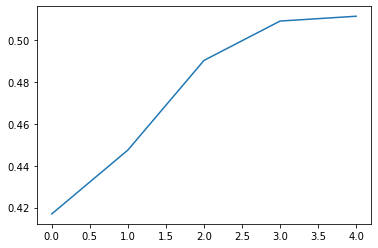

In [18]:
plt.plot(acc)

Check the model with data in testset
------

In [19]:
model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
data = data.view([-1,3,32,32])
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : " + str(predicted.item()))
print("이 이미지 데이터의 정답 레이블 : " + str(y_test[index].item()))


예측 결과 : 7
이 이미지 데이터의 정답 레이블 : 7
